###### World Temperature

In [2]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from math import *
from util import *

plt.rcParams["figure.figsize"] = (8, 6)
palette = sns.color_palette()

## Parseo de datos

In [10]:
df = pd.read_csv('data/worldTemperature.csv')

fechas = list(df['year'])
temps = list(df['temp'])

#res = cml(lambda x: [x*2, x], [1,2,3], [1,1,1])
#res(5)

## f(x) = w1\*x + w2\*1

0.163376334191


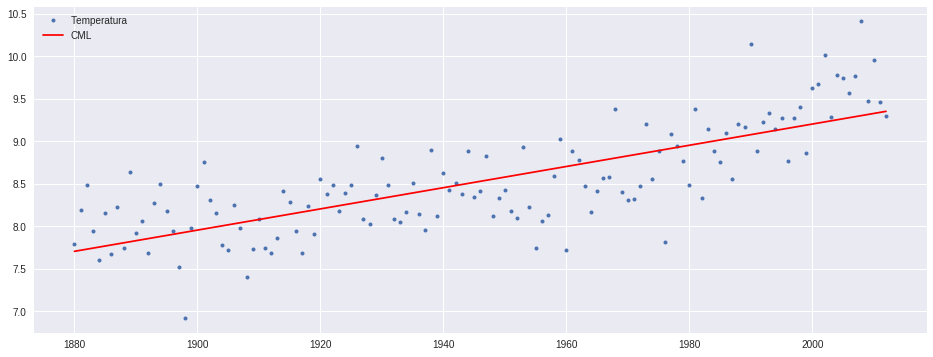

In [11]:
funcionCML = cml(lambda x: [x, 1], fechas, temps)
results = list(map(funcionCML, fechas))

plt.plot(fechas, temps, 'o', label='Temperatura', markersize=4)
plt.plot(fechas, results, 'r', label='CML')
plt.legend()
print(ecm(results, temps))

## f(x) = w1\*x^2 + w2\*x + w3\*1

0.132319040187


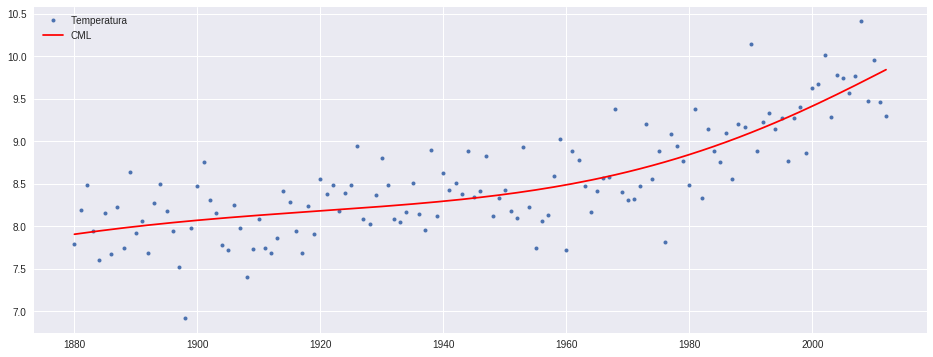

In [12]:
f = cml(poly(30), fechas, temps)
results = list(map(f, fechas))

plt.plot(fechas, temps, 'o', label='Temperatura', markersize=4)
plt.plot(fechas, results, 'r', label='CML')
plt.legend()
print(ecm(results, temps))

## f(x) con grado harcodeado

1 0 1.43895220469
1 1 0.180314756511
1 2 0.245850437342
1 3 1.37348476385
3 0 21.6300524809
3 1 0.329202470485
3 2 0.879824058415
3 3 15.0414897239


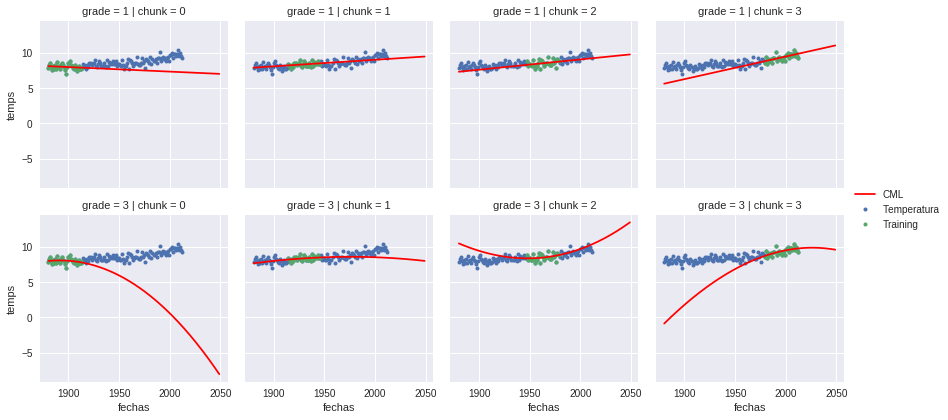

In [13]:
n = 66
lol = fechas + list(range(2013, 2050))
grados = [1, 3]
data = []
for g in grados:
    for c in range(4):
        f = cml(poly(g), fechas_c[c], temps_c[c])
        results = list(map(f, lol))
        data.append([results, g, c])
        print(g, c, ecm(list(map(f, fechas)), temps))

df2 = pd.DataFrame(data, columns=['x', 'grade', 'chunk'])

def pp(x, y, data, **kwargs):
    c = data['chunk'].values[0]
    plt.plot(fechas, temps, 'o', label='Temperatura', markersize=4)
    plt.plot(fechas_c[c], temps_c[c], 'o', label='Training', markersize=4)
    plt.plot(lol, data['x'].values[0], 'r', label='CML')
    
l = sns.FacetGrid(df2, col="chunk", row="grade", size=3)
l.map_dataframe(pp, 'fechas', 'temps')
l.add_legend()

# ECM vs Grado de polinomio

(0.13231904018740376, 30)


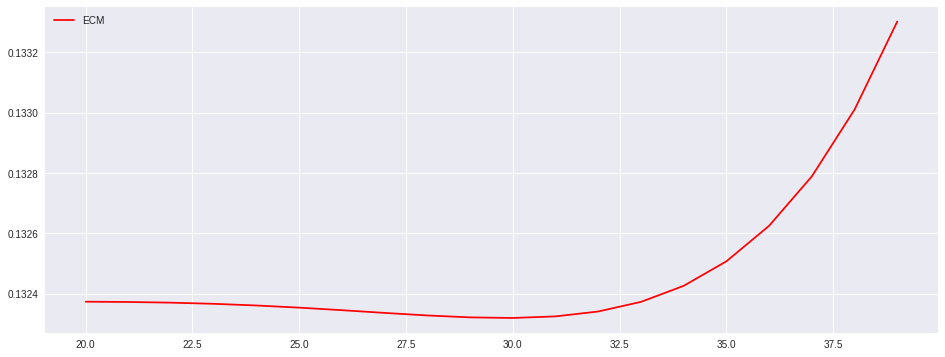

In [14]:
ecms = []

grados = range(20, 40, 1)
for grado in grados:
    f = cml(poly(grado), fechas, temps)
    results = list(map(f, fechas))
    ecms.append(ecm(results, temps))
    
m = min(zip(ecms, grados), key=lambda x: x[0])
print(m)

plt.plot(grados, ecms, 'r', label='ECM')
#plt.plot(fechas, results, 'r', label='CML')
plt.legend()

## Mido cuando comienza el calentamiento global

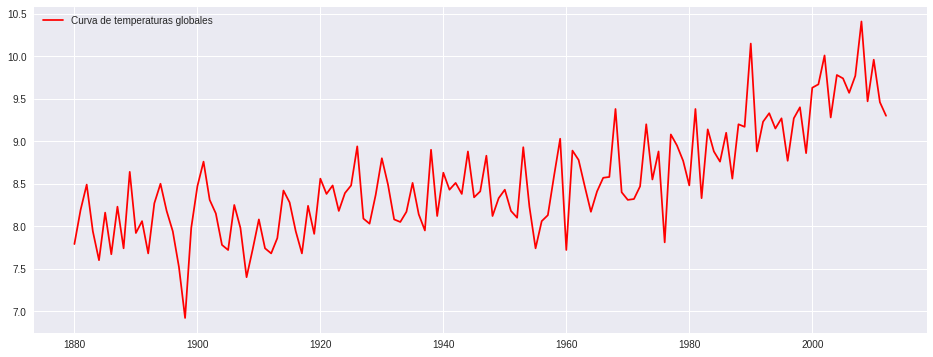

In [15]:
plt.plot(fechas, temps, 'r', label='Curva de temperaturas globales')
plt.legend()
plt.show()

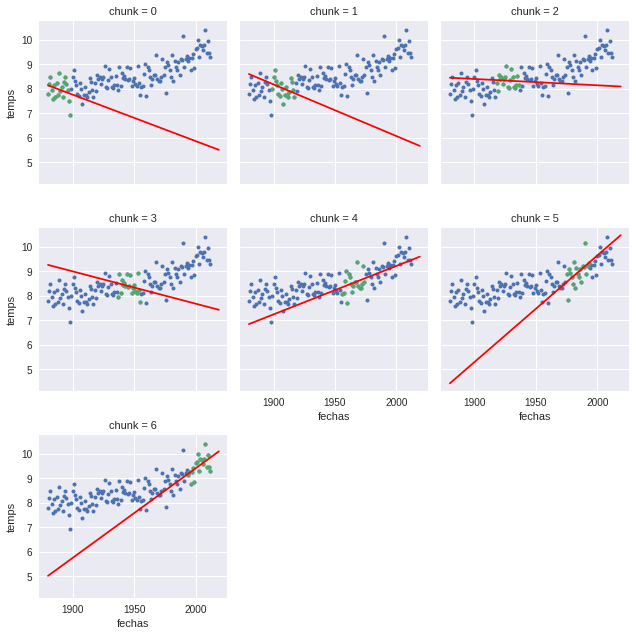

In [12]:
#Parto en 7 chuncks de 20 años (aprox) y veo las pendientes
fechasChunk = np.array_split(fechas,7)
tempChunk = np.array_split(temps,7)

fechasMasRango = fechas + list(range(2013,2020))

data = []
for c in range(7):
    f = cml(poly(1), fechasChunk[c], tempChunk[c])
    results = list(map(f, fechasMasRango))
    data.append([results, c])

df3 = pd.DataFrame(data, columns=['x', 'chunk'])

def pp(x, y, data, **kwargs):
    c = data['chunk'].values[0]
    plt.plot(fechas, temps, 'o', label='Temperatura', markersize=4)
    plt.plot(fechasChunk[c], tempChunk[c], 'o', label='Training', markersize=4)
    plt.plot(fechasMasRango, data['x'].values[0], 'r', label='CML')
    plt.legend()

l = sns.FacetGrid(df3, col="chunk", col_wrap = 3)
l.map_dataframe(pp, 'fechas', 'temps')

error year <= 1900.0 -> 0.22960804993543782
error year <= 1910.0 -> 0.012755794000746334
error year <= 1920.0 -> 0.08980381750311395
error year <= 1930.0 -> 0.08578526596284952
error year <= 1940.0 -> 0.02355632867256041
error year <= 1950.0 -> 0.07881716312879483
error year <= 1960.0 -> -0.0029193972944376867
error year <= 1970.0 -> -0.011062362663544434
error year <= 1980.0 -> -0.05790749793251493


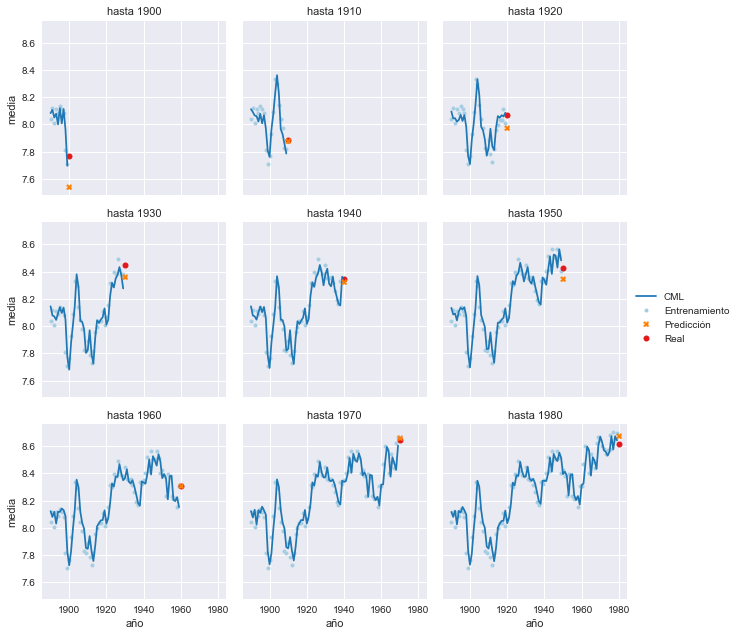

In [110]:
from functools import reduce
palette = sns.color_palette('Paired', 12)
#sns.palplot(palette)
k = 5  # cantidad de valores anteriores para AR. el df arranca en 1880+k
df = pd.read_csv('data/worldTemperature.csv')
df['rolling'] = df.rolling(5)['temp'].mean()
df = colapsarK(df, 'rolling', k, drop=False).drop(df.index[:10])

chunks = 9 # chamuyo para que FacetGrid tenga algo q facetar, no se usa
mult = ceil(len(df)/chunks)
df['chunk'] = reduce(lambda l, i: l + [i]*mult, range(chunks), [])[:len(df)]
df['chunk'] = df['chunk'].apply(lambda c: 1900 + c*10)

nameCols = ['year'] + ['prev'+str(i) for i in range(1, k+1)]

def pp(x, y, data, **kwargs):
    chunk = data.iloc[0]['chunk']
    df_training = df[df['year'] < chunk]
    test = df[df['year'] == chunk]
    
    xs = df_training[nameCols].as_matrix()
    f = cml(lambda x: [1, x[1], x[2], x[3], x[4], x[5]], xs, df_training['rolling'])
    #xs = df_training['year'].as_matrix()
    #f = cml(poly(5), xs, df_training['rolling'])
    
    results_training = list(map(f, xs))
    results_test = f(test[nameCols].as_matrix()[0])
    
    plt.plot(df_training['year'], df_training['rolling'], 'o', label='Entrenamiento', markersize=4, color=palette[0])
    plt.plot(test['year'], test['rolling'], 'o', label='Real', markersize=6, color=palette[5])

    plt.plot(df_training['year'], results_training, 'r', label='CML', color=palette[1])
    plt.plot(test['year'], results_test, 'X', label='Predicción', markersize=6, color=palette[7])
    
    #plt.legend()
    err = test.iloc[0]['rolling'] - results_test
    print('error year <= {} -> {}'.format(chunk, err))

l = sns.FacetGrid(df, col='chunk', col_wrap=3, size=3)
l.map_dataframe(pp, 'year', 'rolling')\
    .set_titles('hasta {col_name}')\
    .set_xlabels('año')\
    .set_ylabels('media')
l.add_legend()
plt.savefig("img/world_temp_cross.png", dpi=200)

In [129]:
total = 0
def calc(chunk):
    df_training = df[df['year'] < chunk]
    test = df[df['year'] == chunk]
    
    #xs = df_training[nameCols].as_matrix()
    #f = cml(lambda x: [1, x[1], x[2], x[3], x[4], x[5]], xs, df_training['rolling'])
    xs = df_training['year'].as_matrix()
    f = cml(poly(5), xs, df_training['rolling'])
    
    results_training = list(map(f, xs))
    results_test = f(test['year'].as_matrix()[0])
    
    err = (test.iloc[0]['rolling'] - results_test)**2
    global total
    total += err
    #print('error year <= {} -> {}'.format(chunk, err))
    
for x in range(1900, 2010 + 1): calc(x)
print(total/(2010-1900))

0.0386822735827


In [75]:
df = pd.read_csv('data/worldTemperature.csv')
df = colapsarK(df, 'temp', k)
nameCols = ['prev'+str(i) for i in range(1,k+1)]

errors = []
for d in range(1880, 1990):
    _, [x], _, df_r = foo2(df, d)
    errors.append((x - df_r['temp'].iloc[0])**2)
sum(errors)/len(range(1880, 1990))

0.17427981759169373

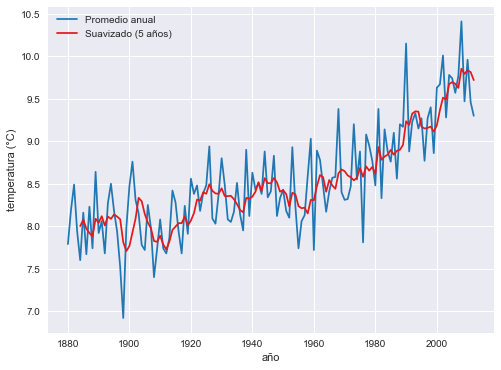

In [29]:
palette = sns.color_palette('Paired')
df = pd.read_csv('data/worldTemperature.csv')
df['rolling'] = df.rolling(5)['temp'].mean()

plt.plot(df['year'], df['temp'], 'r', label='Promedio anual', color=palette[1])
plt.plot(df['year'], df['rolling'], 'r', label='Suavizado (5 años)', color=palette[5])
plt.xlabel('año')
plt.ylabel('temperatura (°C)')
plt.legend()
plt.savefig('world_temp.png', dpi=300)

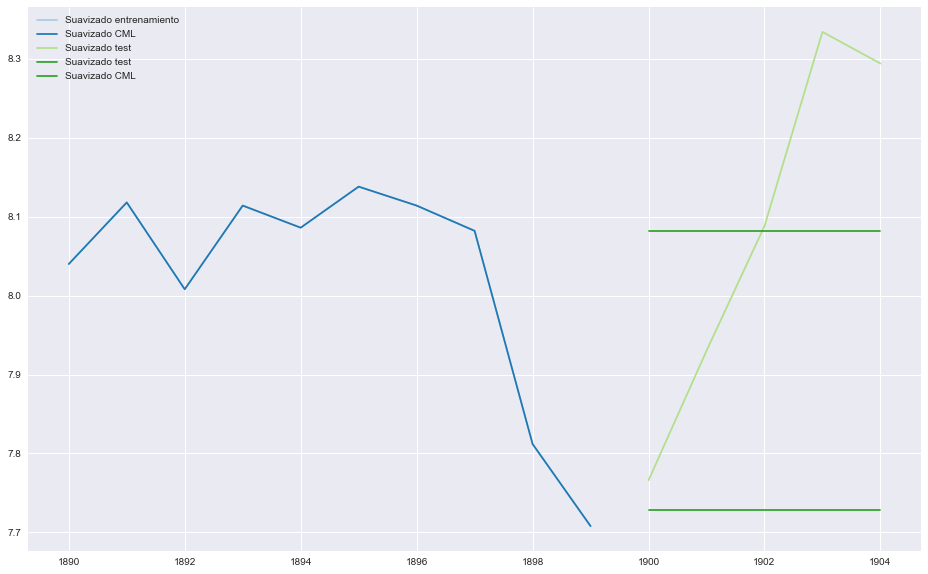

In [60]:
df2 = colapsarK(df, 'rolling', 2, drop=False)
df2 = df2[df2.index > 5]
year = 1890
training_size = 10
test_size = 5

df_training = df2[(df2['year'] >= year) & (df2['year'] < year + training_size)]
f = cml(lambda x: [1, x[0], x[1]], df2[['prev1', 'prev2']].as_matrix(), df2['rolling'])

df_test = df2[(df2['year'] >= year + training_size) & (df2['year'] < year + training_size + test_size)]
results_training = list(map(f, df_training[['prev1','prev2']].as_matrix()))
result = f(df_test[['prev1', 'prev2']].as_matrix()[0])
mean = df_test['rolling'].aggregate('mean')

plt.plot(df_training['year'], df_training['rolling'], 'r', label='Suavizado entrenamiento', markersize=4, color=palette[0])
plt.plot(df_training['year'], df_training['rolling'], 'r', label='Suavizado CML', markersize=4, color=palette[1])
plt.plot(df_test['year'], df_test['rolling'], 'r', label='Suavizado test', markersize=4, color=palette[2])
plt.plot(df_test['year'], [mean] * test_size, 'r', label='Suavizado test', markersize=4, color=palette[3])
plt.plot(df_test['year'], [result] * test_size, 'r', label='Suavizado CML', markersize=4, color=palette[3])
plt.legend()

## Correlacion entre la temperatura y las anteriores

           year      temp     prev1     prev2     prev3     prev4     prev5
year   1.000000  0.766168  0.767760  0.764348  0.749474  0.741620  0.739919
temp   0.766168  1.000000  0.659584  0.664517  0.602701  0.654756  0.653106
prev1  0.767760  0.659584  1.000000  0.657962  0.655020  0.597261  0.659152
prev2  0.764348  0.664517  0.657962  1.000000  0.648508  0.649566  0.592506
prev3  0.749474  0.602701  0.655020  0.648508  1.000000  0.639200  0.627355
prev4  0.741620  0.654756  0.597261  0.649566  0.639200  1.000000  0.632075
prev5  0.739919  0.653106  0.659152  0.592506  0.627355  0.632075  1.000000


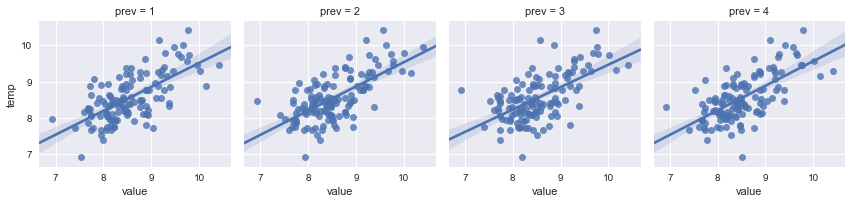

In [89]:
df = pd.read_csv('data/worldTemperature.csv')
df = colapsarK(df, 'temp', 5)
cols = ['prev{}'.format(i+1) for i in range(4)]
print(df.corr())
df = pd.melt(df, id_vars=['year', 'temp'], value_vars=cols)
df['prev'] = df['variable'].apply(lambda x: int(x[4:]))
df = df.sort_values(['year', 'prev'])
sns.lmplot(data=df, x='value', y='temp', col='prev', col_wrap=4, size=3)